In [1]:
from pathlib import Path
import importlib

import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt

from dask.distributed import Client
import dask.array
from dask.dataframe.utils import make_meta

from hats import read_hats
from hats.inspection import plot_pixels
from hats_import.catalog.file_readers import CsvReader
from hats_import.margin_cache.margin_cache_arguments import MarginCacheArguments
from hats_import.pipeline import ImportArguments, pipeline_with_client

import lsdb

from catalog_filtering import bandFilterLenient, contains_PM
import hpms_pipeline as hpms

print("Imported libraries.")

Imported libraries.


In [36]:
bandList = ['G','R','I','Z','Y']
class_star = None
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
check_invalid_mags = True
query_string = bandFilterLenient(bandList,classStar=class_star,spreadModel=spread_model,magError=magnitude_error,flag=check_flags,invalidMags=check_invalid_mags)
des_cols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
k = 2
collinear_error_cutoff = 1000000
pm_speed_min = 2000 #units are milliseconds per year
pm_speed_max = 10**5
cone_search_rad = 50
max_neighbor_dist = 18
milliarc_degree_conversion = 1/(1000*3600)
print("Defined local vars.")

Defined local vars.


,_healpix_29,CLASS_STAR_G_1,CLASS_STAR_R_1,CLASS_STAR_I_1,CLASS_STAR_Z_1,CLASS_STAR_Y_1,FLAGS_G_1,FLAGS_R_1,FLAGS_I_1,FLAGS_Z_1,...,WAVG_MAG_PSF_I_2,WAVG_MAG_PSF_Z_2,WAVG_MAG_PSF_Y_2,WAVG_MAGERR_PSF_G_2,WAVG_MAGERR_PSF_R_2,WAVG_MAGERR_PSF_I_2,WAVG_MAGERR_PSF_Z_2,WAVG_MAGERR_PSF_Y_2,_dist_arcsec,neighbors
0,2368327516244015824,0.46684,0.407244,0.124406,0.000966,0.080243,0,0,0,0,...,23.176750,22.917854,-99.000000,0.042827,0.040490,0.109165,0.157628,-99.000000,0.000000,3
1,2368327516244015824,0.46684,0.407244,0.124406,0.000966,0.080243,0,0,0,0,...,22.719099,22.641958,22.016718,0.064254,0.037155,0.039965,0.071476,0.291113,9.498425,3
2,2368327516244015824,0.46684,0.407244,0.124406,0.000966,0.080243,0,0,0,0,...,22.854977,22.697977,-99.000000,0.052751,0.033780,0.042143,0.106946,-99.000000,14.307634,3
3,2368327516244015824,0.46684,0.407244,0.124406,0.000966,0.080243,0,0,0,0,...,22.597988,22.356052,-99.000000,0.043675,0.023063,0.034745,0.051513,-99.000000,17.211181,3


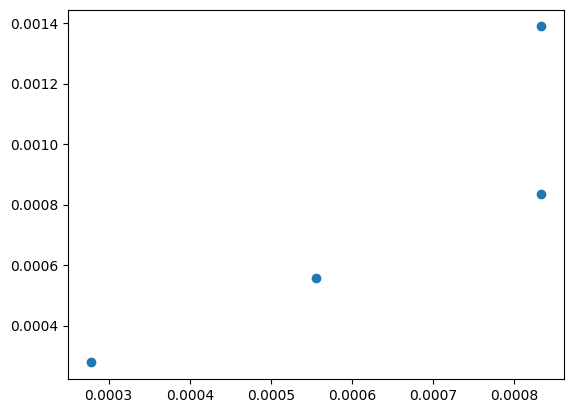

In [70]:
test_1 = pd.read_csv('sample_test.csv')[:4]
test_1['RA_1'] = np.array([1,1,1,1])/3600
test_1['DEC_1'] = np.array([1,1,1,1])/3600
test_1['RA_2'] = np.array([1,2,3,3])/3600
test_1['DEC_2'] = np.array([1,2,3,5])/3600
display(test_1)
plt.scatter(test_1['RA_2'], test_1['DEC_2'])

In [76]:
importlib.reload(hpms)
print("Done")

Done


In [77]:
columns_to_keep = (
        [col for col in test_1.columns if col.endswith('_2')]
    )
meta = make_meta(test_1)
meta['kth_min_proj_error'] = 0.0
meta['max_obj_distance'] = 0.0
star_groups = test_1.groupby('_healpix_29').apply(hpms.kth_star_min_distance, k=k-1, cols_to_keep = columns_to_keep, mag_cols=['WAVG_MAG_PSF_I'], max_obj_deviation=collinear_error_cutoff) 
star_groups

Showing proj_coords=[[0. 0.]
 [1. 1.]
 [2. 2.]
 [2. 4.]]
proj_vector = [1. 1.], proj_coords[2] = [2. 2.], distance_to_line(proj_vector, proj_coords[2]), 1.5700924586930011e-16
proj_vector = [1. 1.], proj_coords[3] = [2. 4.], distance_to_line(proj_vector, proj_coords[3]), 1.414213562364785
0th sorted_neighbors value = 1.5700924586930011e-16
1th sorted_neighbors value = 1.414213562364785
2th sorted_neighbors value = nan
3th sorted_neighbors value = nan
done
proj_vector = [2. 2.], proj_coords[1] = [1. 1.], distance_to_line(proj_vector, proj_coords[1]), 7.850462293465004e-17
proj_vector = [2. 2.], proj_coords[3] = [2. 4.], distance_to_line(proj_vector, proj_coords[3]), 1.4142135623647847
0th sorted_neighbors value = 7.850462293465004e-17
1th sorted_neighbors value = 1.4142135623647847
2th sorted_neighbors value = nan
3th sorted_neighbors value = nan
done
proj_vector = [2. 4.], proj_coords[1] = [1. 1.], distance_to_line(proj_vector, proj_coords[1]), 0.44721359549575324
proj_vector = [2. 4.]

/var/tmp/ipykernel_69356/1605519221.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  star_groups = test_1.groupby('_healpix_29').apply(hpms.kth_star_min_distance, k=k-1, cols_to_keep = columns_to_keep, mag_cols=['WAVG_MAG_PSF_I'], max_obj_deviation=collinear_error_cutoff)


CLASS_STAR_G_2  CLASS_STAR_R_2  CLASS_STAR_I_2  \
_healpix_29                                                             
2368327516244015824 0        0.466840        0.407244        0.124406   
                    1        0.196854        0.026735        0.037937   
                    2        0.009531        0.016209        0.010274   
                    3        0.347446        0.177520        0.219258   

                       CLASS_STAR_Z_2  CLASS_STAR_Y_2  FLAGS_G_2  FLAGS_R_2  \
_healpix_29                                                                   
2368327516244015824 0        0.000966        0.080243          0          0   
                    1        0.010572        0.005375          0          0   
                    2        0.000564        0.000161          0          0   
                    3        0.130893        0.019475          0          0   

                       FLAGS_I_2  FLAGS_Z_2  FLAGS_Y_2  ...  WAVG_MAG_PSF_I_2  \
_healpix_29                                             ...                     
2368327516244015824 0          0          0          0  ...         23.176750   
                    1          0          0          0  ...         22.719099   
                    2          0          0          0  ...         22.854977   
                    3          0          0          0  ...         22.597988   

                       WAVG_MAG_PSF_Z_2  WAVG_MAG_PSF_Y_2  \
_healpix_29                                                 
2368327516244015824 0         22.917854        -99.000000   
                    1         22.641958         22.016718   
                    2         22.697977        -99.000000   
                    3         22.356052        -99.000000   

                       WAVG_MAGERR_PSF_G_2  WAVG_MAGERR_PSF_R_2  \
_healpix_29                                                       
2368327516244015824 0             0.042827             0.040490   
                    1             0.064254             0.037155   
                    2             0.052751             0.033780   
                    3             0.043675             0.023063   

                       WAVG_MAGERR_PSF_I_2  WAVG_MAGERR_PSF_Z_2  \
_healpix_29                                                       
2368327516244015824 0             0.109165             0.157628   
                    1             0.039965             0.071476   
                    2             0.042143             0.106946   
                    3             0.034745             0.051513   

                       WAVG_MAGERR_PSF_Y_2  kth_min_proj_error  \
_healpix_29                                                      
2368327516244015824 0           -99.000000                 NaN   
                    1             0.291113                 NaN   
                    2           -99.000000                 NaN   
                    3           -99.000000            0.894427   

                       max_obj_distance  
_healpix_29                              
2368327516244015824 0               NaN  
                    1               NaN  
                    2               NaN  
                    3          4.472136  

[4 rows x 30 columns]

In [ ]:
df_test_1